In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np
import pandas as pd
from kaggle.competitions import twosigmanews

env_parallel = twosigmanews.make_env()
(marketdf, newsdf) = env_parallel.get_training_data()

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

def prepare_data(marketdf, newsdf):
    # a bit of feature engineering
    marketdf['time'] = marketdf.time.dt.strftime("%Y%m%d").astype(int)
    marketdf['bartrend'] = marketdf['close'] / marketdf['open']
    marketdf['average'] = (marketdf['close'] + marketdf['open'])/2
    marketdf['pricevolume'] = marketdf['volume'] * marketdf['close']
    
    newsdf['time'] = newsdf.time.dt.strftime("%Y%m%d").astype(int)
    newsdf['assetCode'] = newsdf['assetCodes'].map(lambda x: list(eval(x))[0])
    newsdf['position'] = newsdf['firstMentionSentence'] / newsdf['sentenceCount']
    newsdf['coverage'] = newsdf['sentimentWordCount'] / newsdf['wordCount']

    # filter pre-2012 data, no particular reason
    marketdf = marketdf.loc[marketdf['time'] > 20120000]
    
    # get rid of extra junk from news data
    droplist = ['sourceTimestamp','firstCreated','sourceId','headline','takeSequence','provider','firstMentionSentence',
                'sentenceCount','bodySize','headlineTag','marketCommentary','subjects','audiences','sentimentClass',
                'assetName', 'assetCodes','urgency','wordCount','sentimentWordCount']
    newsdf.drop(droplist, axis=1, inplace=True)
    marketdf.drop(['assetName', 'volume'], axis=1, inplace=True)
    
    # combine multiple news reports for same assets on same day
    newsgp = newsdf.groupby(['time','assetCode'], sort=False).aggregate(np.mean).reset_index()
    
    # join news reports to market data, note many assets will have many days without news data
    return pd.merge(marketdf, newsgp, how='left', on=['time', 'assetCode'], copy=False) #, right_on=['time', 'assetCodes'])


def post_scaling(df):
    mean, std = np.mean(df), np.std(df)
    df = (df - mean)/ (std * 8)
    return np.clip(df,-1,1)



   

Exception: You can only make one environment for this competition.

# 直接对数据进行截断

In [ ]:
### 对target value进行截断
left_threshold = -0.2
right_threshold = 0.2
trainset_drop_index_left = ttt[ttt < left_threshold].index
ttt_drop_left = ttt.drop(trainset_drop_index_left, axis='index')
ttt_drop_left.reset_index(drop=True)
trainset_drop_index_right = ttt_drop_left[ttt_drop_left > right_threshold].index
ttt_clean = ttt_drop_left.drop(trainset_drop_index_right, axis='index')
sns.distplot(ttt_clean,bins=100)

# 取一部分数据

# data analysis

In [ ]:
trainset_all_returns=marketdf.iloc[:,-10:-1].copy()
trainset_all_returns.describe

returnsClosePrevRaw1 output
returnsOpenPrevRaw1 output
returnsClosePrevMktres1 output
returnsOpenPrevMktres1 output
returnsClosePrevRaw10 output
returnsOpenPrevRaw10 output
returnsClosePrevMktres10 output
returnsOpenPrevMktres10 output
returnsOpenNextMktres10 output


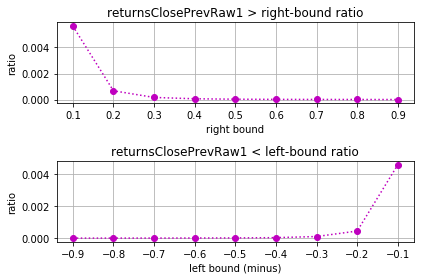

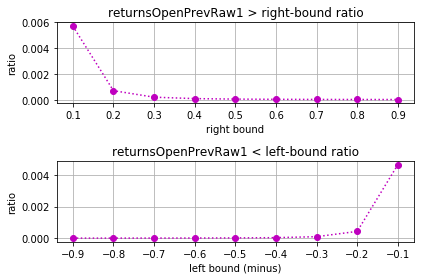

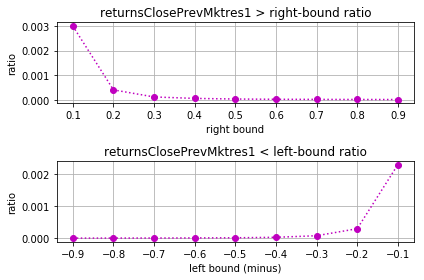

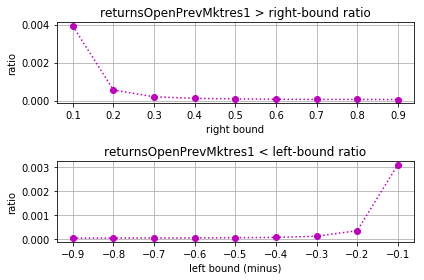

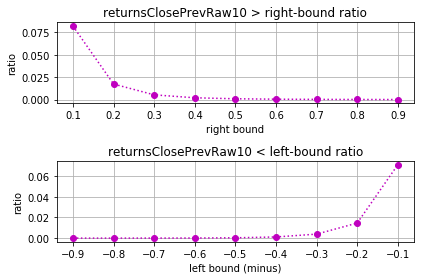

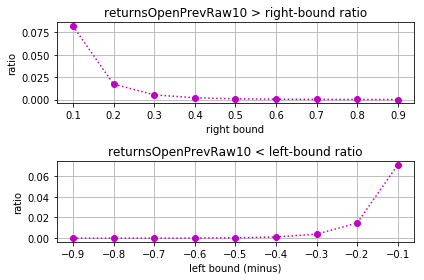

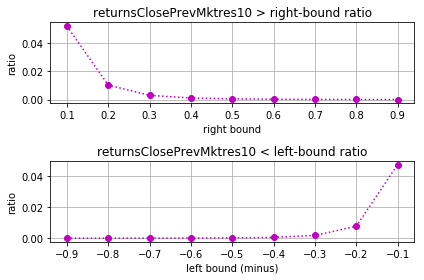

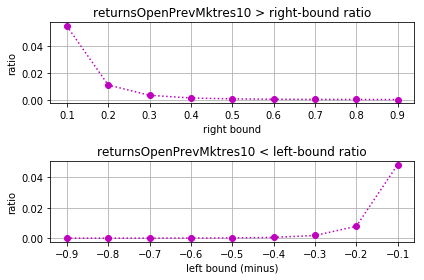

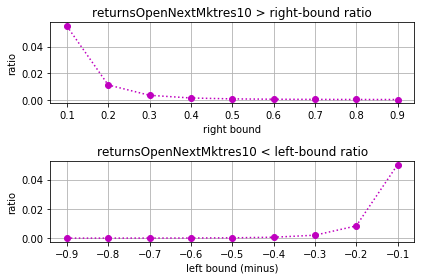

In [57]:
#### 分析左右两侧的取值情况
def left_and_right_bound(ttt,col_name):
    ### right threshold 
    type(ttt)
    pos_threshold = [i*(1e-1) for i in range(1,10)]
    train_set_length = len(marketdf.index)
    pos_percent = []
    for val in pos_threshold:
        pos_percent.append(sum(ttt>val)/train_set_length)
    plt.figure()
    plt.subplot(211)
    plt.plot(pos_threshold,pos_percent,'mo:')
    plt.xlabel('right bound')
    plt.ylabel('ratio')
    plt.title(col_name + ' > right-bound ratio')
    plt.grid()
    #### left threshold 
    neg_threshold = [i*(1e-1) for i in range(1,10)]
    neg_threshold = [-1*x for x in neg_threshold][::-1]
    train_set_length = len(marketdf.index)
    neg_percent = []
    for val in neg_threshold:
        neg_percent.append(sum(ttt<val)/train_set_length)
    plt.subplot(212)
    plt.plot(neg_threshold,neg_percent,'mo:')
    plt.xlabel('left bound (minus)')
    plt.ylabel('ratio')
    plt.title(col_name + ' < left-bound ratio')
    plt.grid()
    plt.tight_layout()

### 对数据进行截断分析
col_name = trainset_all_returns.columns.tolist()
for i in range(len(col_name)):
    left_and_right_bound(trainset_all_returns.loc[:,col_name[i]],col_name[i])
    print(col_name[i] + ' output')
    

# data clip and fill NaN

In [58]:
left_bound = -0.3
right_bound = 0.3
trainset_all_returns_raw = trainset_all_returns.copy()
col_name = trainset_all_returns.columns.tolist()
for i in range(len(col_name)):
    ## clip操作
    trainset_all_returns.loc[:,col_name[i]].clip(left_bound,right_bound, inplace=True)
    print(col_name[i],'in trainset have been clipped')
    ## 填充空值
    trainset_all_returns.loc[:,col_name[i]].fillna(0, inplace=True)
    print(col_name[i],'in trainset have been filled nan')
    

returnsClosePrevRaw1 in trainset have been clipped
returnsClosePrevRaw1 in trainset have been filled nan
returnsOpenPrevRaw1 in trainset have been clipped
returnsOpenPrevRaw1 in trainset have been filled nan
returnsClosePrevMktres1 in trainset have been clipped
returnsClosePrevMktres1 in trainset have been filled nan
returnsOpenPrevMktres1 in trainset have been clipped
returnsOpenPrevMktres1 in trainset have been filled nan
returnsClosePrevRaw10 in trainset have been clipped
returnsClosePrevRaw10 in trainset have been filled nan
returnsOpenPrevRaw10 in trainset have been clipped
returnsOpenPrevRaw10 in trainset have been filled nan
returnsClosePrevMktres10 in trainset have been clipped
returnsClosePrevMktres10 in trainset have been filled nan
returnsOpenPrevMktres10 in trainset have been clipped
returnsOpenPrevMktres10 in trainset have been filled nan
returnsOpenNextMktres10 in trainset have been clipped
returnsOpenNextMktres10 in trainset have been filled nan


# 绘制returns的数据分布

plotting: returnsClosePrevRaw1
plotting: returnsOpenPrevRaw1
plotting: returnsClosePrevMktres1
plotting: returnsOpenPrevMktres1
plotting: returnsClosePrevRaw10
plotting: returnsOpenPrevRaw10
plotting: returnsClosePrevMktres10
plotting: returnsOpenPrevMktres10
plotting: returnsOpenNextMktres10


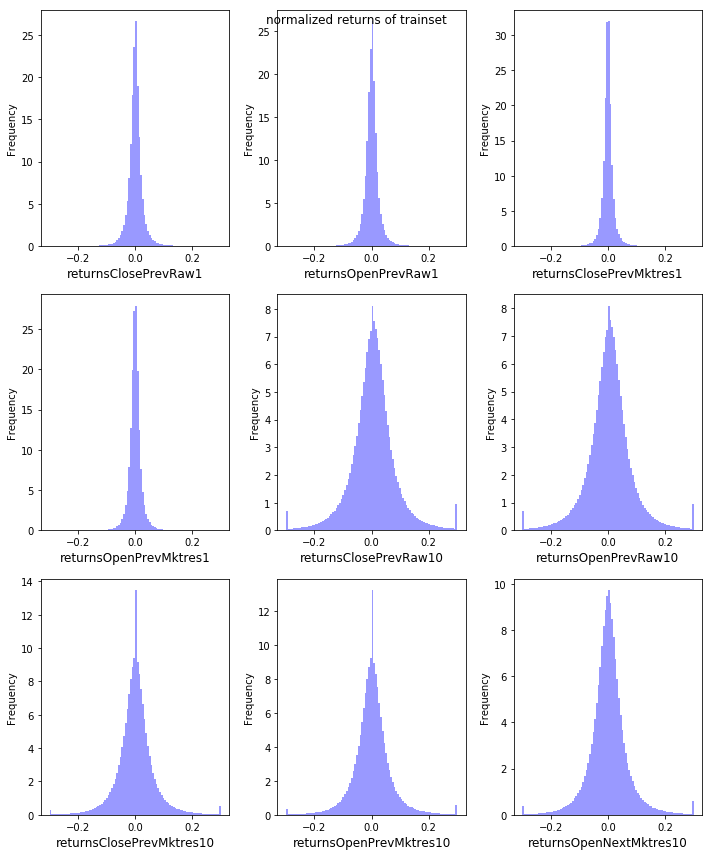

In [67]:
plt.figure(figsize=(10, 12))
col_name = trainset_all_returns.columns.tolist()
for i in range(len(col_name)):
    print('plotting:', col_name[i])
    plt.subplot(3,len(col_name)//3,i+1)
    sns.distplot(trainset_all_returns.loc[:, col_name[i]].tolist(), bins=100, kde=False, norm_hist=True, color='b')
    plt.xlabel(col_name[i], fontsize=12)
    plt.ylabel('Frequency')    
plt.tight_layout()
plt.suptitle('normalized returns of trainset',fontdict={'fontsize':20, 'fontweight':'medium'})
plt.show()

plotting: returnsClosePrevRaw1
plotting: returnsOpenPrevRaw1
plotting: returnsClosePrevMktres1
plotting: returnsOpenPrevMktres1
plotting: returnsClosePrevRaw10
plotting: returnsOpenPrevRaw10
plotting: returnsClosePrevMktres10
plotting: returnsOpenPrevMktres10
plotting: returnsOpenNextMktres10


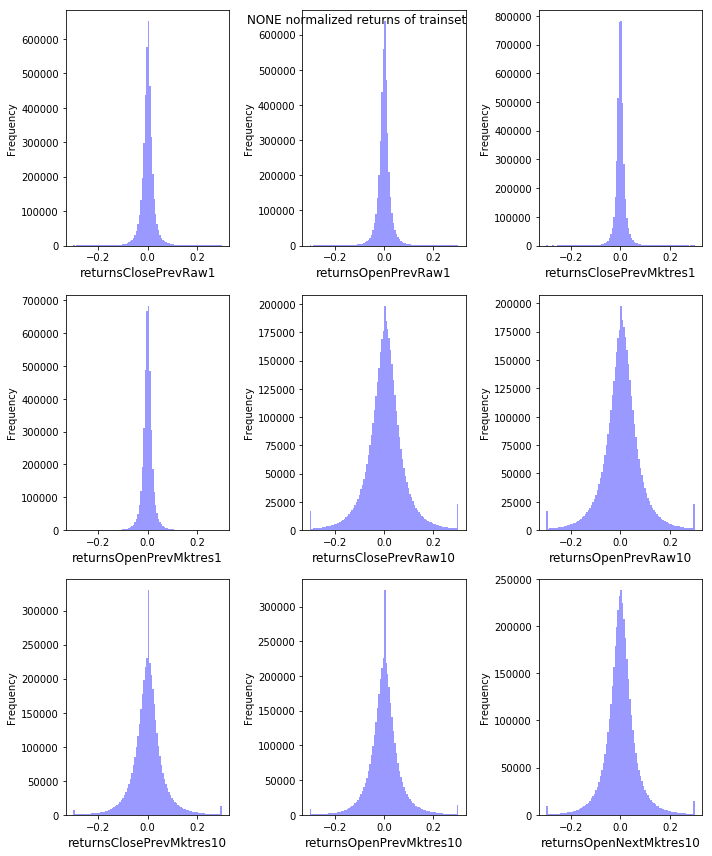

In [69]:
plt.figure(figsize=(10, 12))
col_name = trainset_all_returns.columns.tolist()
for i in range(len(col_name)):
    print('plotting:', col_name[i])
    plt.subplot(3,len(col_name)//3,i+1)
    sns.distplot(trainset_all_returns.loc[:, col_name[i]].tolist(), bins=100, kde=False, norm_hist=False, color='b')
    plt.xlabel(col_name[i], fontsize=12)
    plt.ylabel('Frequency')    
plt.tight_layout()
plt.suptitle('NONE normalized returns of trainset',fontdict={'fontsize':20, 'fontweight':'medium'})
plt.show()

* # 研究returnsOpenNextMktres10和其他的returns的叠加

plotting: returnsClosePrevRaw1
plotting: returnsOpenPrevRaw1
plotting: returnsClosePrevMktres1
plotting: returnsOpenPrevMktres1
plotting: returnsClosePrevRaw10
plotting: returnsOpenPrevRaw10
plotting: returnsClosePrevMktres10
plotting: returnsOpenPrevMktres10
plotting: returnsOpenNextMktres10


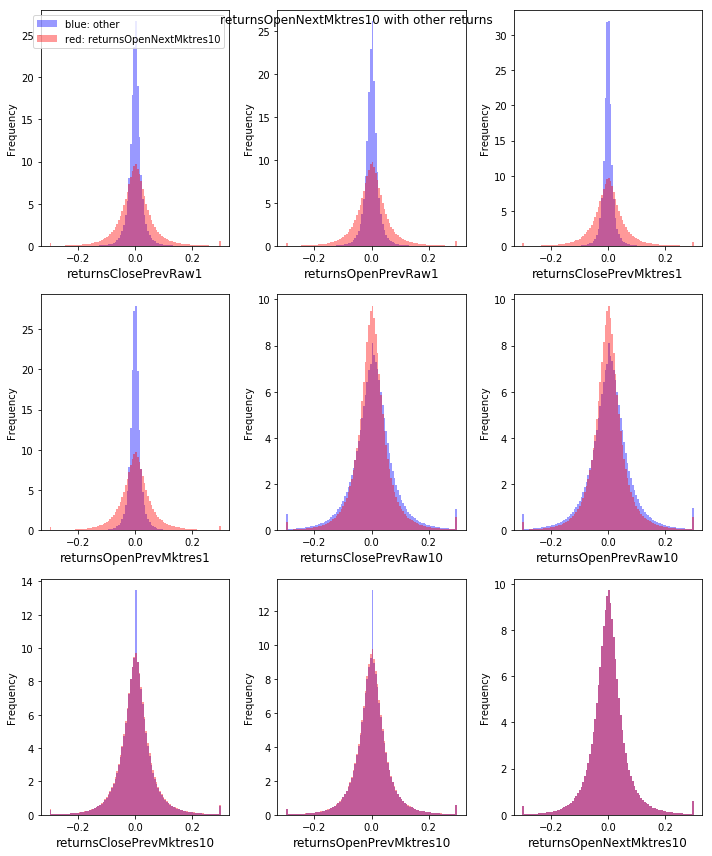

In [78]:
plt.figure(figsize=(10, 12))
col_name = trainset_all_returns.columns.tolist()
for i in range(len(col_name)):
    print('plotting:', col_name[i])
    plt.subplot(3,len(col_name)//3,i+1)
    sns.distplot(trainset_all_returns.loc[:, col_name[i]].tolist(), bins=100, kde=False, norm_hist=True, color='b')
    sns.distplot(trainset_all_returns.loc[:, 'returnsOpenNextMktres10'].tolist(), bins=100, kde=False, norm_hist=True, color='r')
    if i == 0:
        plt.legend(['blue: other','red: returnsOpenNextMktres10'])
    plt.xlabel(col_name[i], fontsize=12)
    plt.ylabel('Frequency')    
plt.tight_layout()
plt.suptitle('returnsOpenNextMktres10 with other returns',fontdict={'fontsize':20, 'fontweight':'medium'})
plt.show()

In [ ]:
print()